In [2]:
using MPSTime
using Random
using Plots
using PrettyTables
using DSP
using Statistics
using Serialization
using Base.Threads

In [3]:
macro noprint(expr)
    quote
        let so = stdout
            redirect_stdout(devnull)
            res = $(esc(expr))
            redirect_stdout(so)
            res
        end
    end
end;

able to set each variable as a vector as to determine the relationships better and also have a single function perform the multistep forecasting

In [4]:
function params(d::Union{Int, Vector},
    chi_max::Union{Int, Vector},
    ntimepoints::Union{Int, Vector},
    ntrain_instances::Union{Int, Vector},
    ntest_instances::Union{Int, Vector},
    sigma::Union{Number, Vector};
    period::Union{Number, Vector}=nothing,
    final_multiplier::Union{Number, Vector}=20,
    sweeps::Union{Int, Vector}=20,
    )

    rng = Xoshiro(1)

    params = Dict(
    :d => d,
    :chi_max => chi_max,
    :ntimepoints => ntimepoints,
    :ntrain_instances => ntrain_instances,
    :ntest_instances => ntest_instances,
    :sigma => sigma,
    :period => period,
    :final_multiplier => final_multiplier,
    :rng => rng,
    :sweeps => sweeps
    )

    return params
end;


In [5]:
function get_test_losses(params::Dict)
    d = params[:d]
    chi_max = params[:chi_max]
    ntimepoints = params[:ntimepoints]
    ntrain_instances = params[:ntrain_instances]
    ntest_instances = params[:ntest_instances]
    sigma = params[:sigma]
    period = params[:period]
    class = 0
    instance_idx = 1
    impute_sites = [ntimepoints]
    method = :median
    rng = params[:rng]
    sweeps = params[:sweeps]

    X_train, info_train = trendy_sine(ntimepoints, ntrain_instances; sigma = sigma,slope = 0, rng = rng,period = period);
    X_test, info_test = trendy_sine(ntimepoints, ntest_instances; sigma = sigma,slope = 0, rng = rng, period = period);

    # println(typeof(info_test[:phase]))

    opts = MPSOptions(d = d, chi_max = chi_max, sigmoid_transform = false, nsweeps = sweeps)

    mps, info, test_states = @noprint fitMPS(X_train, opts);

    imp = @noprint init_imputation_problem(mps,X_test);

    _, _, _, stats, _ = @noprint MPS_impute(imp, class, instance_idx, impute_sites, method);

    return stats[1], info_train, info_test
end;

In [6]:

function grid_search(params::Dict)
    
    param_name, param_values = "", []

    for (key, value) in params
        if isa(value, Vector)
            param_name, param_values = key, value
            println(param_name, " ", param_values)
            break
        end
    end

    if param_name == ""
        error("No vector parameter found for grid search.")
    end

    results = Array{Number, 2}(undef, length(param_values), 5)
    results[:,:] .= 0.0
    train_phases = Array{Vector{Float64}, 1}(undef, length(param_values))
    test_phases = Array{Vector{Float64}, 1}(undef, length(param_values))
    println("Begun Looping")
    for (i,value) in enumerate(param_values)
        
        updated_params = deepcopy(params)
        updated_params[param_name] = value

        rng = Xoshiro(1)

        updated_params[:rng] = rng

        loss, info_train, info_test = get_test_losses(updated_params)

        train_phases[i] = info_train[:phase]
        test_phases[i] = info_test[:phase]

        results[i,:] .= [value, loss[:MAE], loss[:MAPE],loss[:NN_MAE], loss[:NN_MAPE]]
        println("Completed Parameters: ", i, " of ", length(param_values))
    end;

    return results, train_phases, test_phases
end;

In [7]:
# function grid_search_N(params::Dict, num_searches::Int)
    
#     param_name, param_values = "", []

#     for (key, value) in params
#         if isa(value, Vector)
#             param_name, param_values = key, value
#             println(param_name, " ", param_values)
#             break
#         end
#     end
#     return param_name, param_values, mean_results, std_results, train_phases, test_phases, all_results

#     if param_name == ""
#         error("No vector parameter found for grid search.")
#     end

#     # Initialize arrays to store results for averaging and error calculations
#     all_results = Array{Number, 3}(undef, length(param_values), 5, num_searches)
#     all_results[:,:,:] .= 0.0
#     train_phases = Array{Vector{Float64}, 2}(undef, length(param_values), num_searches)
#     test_phases = Array{Vector{Float64}, 2}(undef, length(param_values), num_searches)

#     println("Begun Grid Search Looping")

#     for n in 1:num_searches
#         println("Grid Search Iteration: ", n, " of ", num_searches)
#         for (i, value) in enumerate(param_values)
            
#             updated_params = deepcopy(params)
#             updated_params[param_name] = value

#             rng = Xoshiro(Int64(round(value*100000)) + n)  # Change seed per iteration
#             updated_params[:rng] = rng

#             loss, info_train, info_test = get_test_losses(updated_params)

#             train_phases[i, n] = info_train[:phase]
#             test_phases[i, n] = info_test[:phase]

#             all_results[i,:,n] .= [value, loss[:MAE], loss[:MAPE], loss[:NN_MAE], loss[:NN_MAPE]]
#             println("Completed Parameters: ", i, " of ", length(param_values))
#         end
#     end

#     # Calculate mean and standard deviation across grid searches
#     mean_results = mean(all_results, dims=3)
#     std_results = std(all_results, dims=3)

#     # Squeeze the singleton dimension
#     mean_results = dropdims(mean_results, dims=3)
#     std_results = dropdims(std_results, dims=3)

#     return mean_results, std_results, train_phases, test_phases
# end;

In [8]:
# function grid_search_N(params::Dict, num_searches::Int)
    
#     param_name, param_values = "", []
#     println(typeof(params[:rng]))
#     for (key, value) in params
#         if isa(value, Vector)
#             param_name, param_values = key, value
#             println(param_name, " ", param_values)
#             break
#         end
#     end

#     if param_name == ""
#         error("No vector parameter found for grid search.")
#     end

#     # Initialize arrays to store results for averaging and error calculations
#     all_results = Array{Number, 3}(undef, length(param_values), 5, num_searches)
#     all_results[:,:,:] .= 0.0
#     train_phases = Array{Vector{Float64}, 2}(undef, length(param_values), num_searches)
#     test_phases = Array{Vector{Float64}, 2}(undef, length(param_values), num_searches)

#     println("Begun Grid Search Looping")

#     for n in 1:num_searches
#         println("Grid Search Iteration: ", n, " of ", num_searches)
#         for (i, value) in enumerate(param_values)
            
#             updated_params = deepcopy(params)
#             updated_params[param_name] = value

#             rng = Xoshiro(1)
#             updated_params[:rng] = rng


#             loss, info_train, info_test = get_test_losses(updated_params)

#             train_phases[i, n] = info_train[:phase]
#             test_phases[i, n] = info_test[:phase]

#             all_results[i,:,n] .= [value, loss[:MAE], loss[:MAPE], loss[:NN_MAE], loss[:NN_MAPE]]
#             println("Completed Parameters: ", i, " of ", length(param_values))
#         end
#     end

#     # Calculate mean and standard deviation across grid searches
#     mean_results = mean(all_results, dims=3)
#     std_results = std(all_results, dims=3)

#     # Squeeze the singleton dimension
#     mean_results = dropdims(mean_results, dims=3)
#     std_results = dropdims(std_results, dims=3)

#     # Save raw results
#     @info "Saving raw results..."
#     raw_results_file = "$(param_name)_$(param_values)_sigma=$(params[:sigma])_chi_max=$(params[:chi_max])_d=$(params[:d])_period=$(params[:period]).jls"
#     serialize(raw_results_file, (all_results, train_phases, test_phases))
#     @info "Raw results saved to $raw_results_file"

#     # Return raw results along with mean and std
#     return param_name, param_values, mean_results, std_results, train_phases, test_phases, all_results
# end;

In [9]:
function grid_search_N(params::Dict, num_searches::Int)
    param_name, param_values = "", []

    for (key, value) in params
        if isa(value, Vector)
            param_name, param_values = key, value
            println(param_name, " ", param_values)
            break
        end
    end

    if param_name == ""
        error("No vector parameter found for grid search.")
    end

    num_params = length(param_values)
    num_metrics = 5 

    # Initialize arrays to store results for averaging and error calculations
    all_results = Array{Number, 3}(undef, num_params, num_metrics, num_searches)
    all_results[:,:,:] .= 0.0
    train_phases = Array{Vector{Float64}, 2}(undef, num_params, num_searches)
    test_phases = Array{Vector{Float64}, 2}(undef, num_params, num_searches)

    println("Begun Grid Search Looping")

    Threads.@threads for n in 1:num_searches
        println("Grid Search Iteration: ", n, " of ", num_searches)
        local_results = Array{Number, 2}(undef, num_params, num_metrics)
        local_train_phases = Vector{Vector{Float64}}(undef, num_params)
        local_test_phases = Vector{Vector{Float64}}(undef, num_params)

        for (i, value) in enumerate(param_values)
            updated_params = deepcopy(params)
            updated_params[param_name] = value
            updated_params[:rng] = Xoshiro(1)  # Ensure each thread has its own RNG instance

            loss, info_train, info_test = get_test_losses(updated_params)

            local_train_phases[i] = info_train[:phase]
            local_test_phases[i] = info_test[:phase]
            local_results[i, :] = [value, loss[:MAE], loss[:MAPE], loss[:NN_MAE], loss[:NN_MAPE]]
        end

        # Store the results back into the shared arrays
        all_results[:, :, n] .= local_results
        train_phases[:, n] .= local_train_phases
        test_phases[:, n] .= local_test_phases
    end

    # Calculate mean and standard deviation across grid searches
    mean_results = dropdims(mean(all_results, dims=3), dims=3)
    std_results = dropdims(std(all_results, dims=3), dims=3)

    # Save raw results
    @info "Saving raw results..."
    raw_results_file = "$(param_name)_$(param_values)_sigma=$(params[:sigma])_chi_max=$(params[:chi_max])_d=$(params[:d])_period=$(params[:period]).jls"
    serialize(raw_results_file, (all_results, train_phases, test_phases))
    @info "Raw results saved to $raw_results_file"

    return param_name, param_values, mean_results, std_results, train_phases, test_phases, all_results
end;

In [10]:
d = 5
chi_max = 40
ntimepoints = convert.(Int,vcat(range(3,21,10)))
ntrain_instances = 1000
ntest_instances = 500
period = 100
sigma = 0
sweeps = 20
final_multiplier = 1
num_searches = 10

println(typeof(ntimepoints), ntimepoints)

test_params = params(d, chi_max, ntimepoints, ntrain_instances, ntest_instances, sigma; period = period, final_multiplier = final_multiplier, sweeps = sweeps)

param_name, param_values, mean_results, std_results, train_phases, test_phases, all_results = grid_search_N(test_params, num_searches)

Vector{Int64}[3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
ntimepoints [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
Begun Grid Search Looping
Grid Search Iteration: 1 of 10
Grid Search Iteration: 2 of 10
Grid Search Iteration: 3 of 10
Grid Search Iteration: 4 of 10
Grid Search Iteration: 5 of 10
Grid Search Iteration: 6 of 10
Grid Search Iteration: 7 of 10
Grid Search Iteration: 8 of 10
Grid Search Iteration: 9 of 10
Grid Search Iteration: 10 of 10


┌ Info: Saving raw results...
└ @ Main c:\Users\Lukas Robinson\Documents\GitHub\Stationary-MPS-Honours\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X11sZmlsZQ==.jl:56
┌ Info: Raw results saved to ntimepoints_[3, 5, 7, 9, 11, 13, 15, 17, 19, 21]_sigma=0_chi_max=40_d=5_period=100.jls
└ @ Main c:\Users\Lukas Robinson\Documents\GitHub\Stationary-MPS-Honours\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X11sZmlsZQ==.jl:59


(:ntimepoints, [3, 5, 7, 9, 11, 13, 15, 17, 19, 21], Number[3.0 0.11918854656934208 … 0.003438411036398248 0.009485571226260698; 5.0 0.040751687030719075 … 0.006201923559266631 0.010553740348182862; … ; 19.0 0.04292531499222518 … 0.0007257142634742308 0.001427237746379735; 21.0 0.03477671533084348 … 0.0010808975270096832 0.0011032080170519515], [0.0 0.0 … 0.0 1.828559098217032e-18; 0.0 0.0 … 0.0 1.828559098217032e-18; … ; 0.0 0.0 … 0.0 2.28569887277129e-19; 0.0 0.0 … 0.0 0.0], [[0.4609744004427902, 2.194348995843225, 4.390857551235271, 3.9475037855390043, 5.748668472926759, 1.2114491231010585, 4.839185845713681, 4.90414716949456, 4.211392655002153, 1.0537662432142658  …  2.5019751542867903, 1.425737965753172, 4.9005259296499375, 0.8329873027265214, 5.492311221431894, 1.8807216555775135, 3.261127943936679, 2.2377123396423726, 5.706347746167358, 4.108438934021861] [0.4609744004427902, 2.194348995843225, 4.390857551235271, 3.9475037855390043, 5.748668472926759, 1.2114491231010585, 4.83918

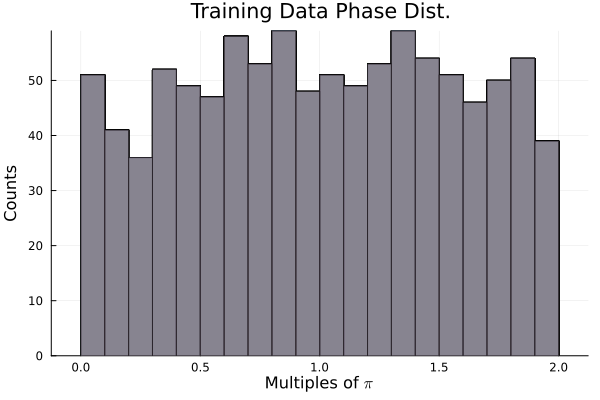

Note if the seed is the same then there are overlaps


In [11]:
b_range = range(0, 2, length=21)
hist = histogram(train_phases[:]./pi, bins = b_range, alpha = 0.2, legend = false)
xlabel!("Multiples of \$\\pi\$")
ylabel!("Counts")
title!("Training Data Phase Dist.")
println("Note if the seed is the same then there are overlaps")
display(hist)
# histogram(x, label="Experimental", bins=b_range)

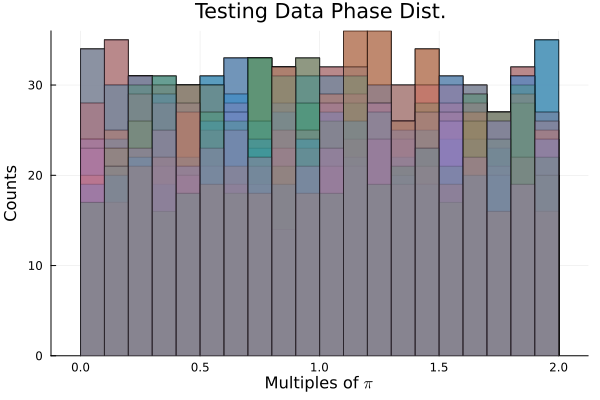

Note if the seed is the same then there are overlaps


In [12]:
b_range = range(0, 2, length=21)
hist = histogram(test_phases[:]./pi, bins = b_range, alpha = 0.2, legend = false)
xlabel!("Multiples of \$\\pi\$")
ylabel!("Counts")
title!("Testing Data Phase Dist.")
println("Note if the seed is the same then there are overlaps")
display(hist)
# histogram(x, label="Experimental", bins=b_range)

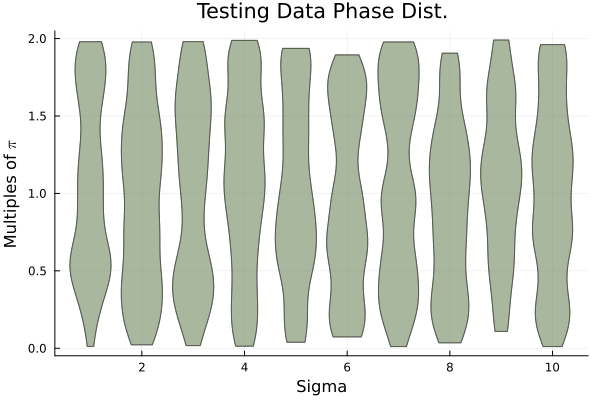

Note if the seed is the same then there are overlaps


In [13]:
b_range = range(0, 2, length=11)
data = test_phases[1,:]./pi  # Normalize by π

# data = vcat([test_phases[i, :]./pi for i in 1:size(test_phases)[2]]...)current_vals[:]

group = repeat(collect(1:size(test_phases)[1]), inner=size(test_phases, 2))

# Create the violin plot
v = violin(group, data,
    bins=b_range, 
    alpha=0.1, 
    legend=false, 
    xlabel="Sigma", 
    ylabel="Multiples of \$\\pi\$", 
    title="Testing Data Phase Dist." #, xlims = [0,10]
)

# v = violin(data, bins=b_range, 
#     alpha=0.5, 
#     legend=false, 
#     xlabel="Sigma", 
#     ylabel="Multiples of \$\\pi\$", 
#     title="Testing Data Phase Dist." #, xlims = [0,10]
# )

display(v)
println("Note if the seed is the same then there are overlaps")

In [14]:
println(size(all_results))
println(size(std_results))
println(size(std_results[1]))

(10, 5, 10)
(10, 5)
()


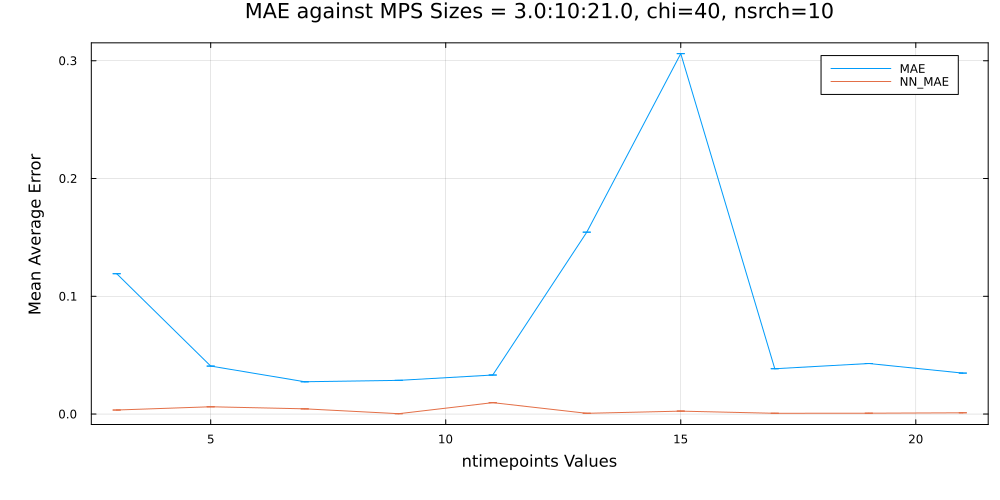

(10, 4)


In [15]:
using Plots.PlotMeasures

values = mean_results[:, 1]
losses = mean_results[:, 2:end]
errors = std_results[:, 2:end]

width = 1000
height = 500

println(size(errors))

gr(display_type=:inline)

p = plot(size = (width, height), framestyle=:box, bottom_margin = 10mm, left_margin = 10mm, top_margin = 5mm)
plot!(values[:], losses[:, 1], yerror=errors[:, 1], markerstrokecolor = :auto, label="MAE", 
    title="MAE against MPS Sizes = $(minimum(values)):$(length(values)):$(maximum(values)), chi=$(test_params[:chi_max]), nsrch=$num_searches", xlabel="$(param_name) Values", ylabel="Mean Average Error", legend=:topright)
plot!(values[:], losses[:, 3], yerror=errors[:, 3], markerstrokecolor = :auto, label="NN_MAE")

display(p)

In [30]:
savefig(p, "LossesVSWindow_Size_fixedseed_chi=$(chi_max)_Nsearches=$(num_searches)_Sigma=$(sigma)_ntimepoints=$(minimum(ntimepoints)):$(maximum(ntimepoints))_period=$(period).png")

"LossesVSWindow_Size_fixedseed_chi=40_Nsearches=10_Sigma=0_ntimepoints=3:21_period=100.png"

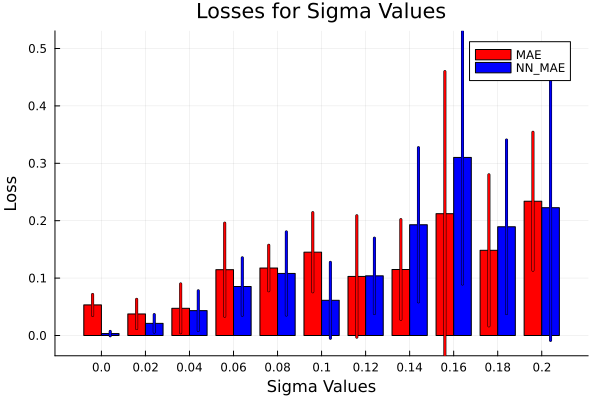

In [ ]:
bar_width = 0.4

x = collect(1:length(values))

x_shift1 = x .- bar_width/2
x_shift2 = x .+ bar_width/2

grouped_losses = [losses[:, 1] losses[:, 3]]
grouped_errors = [errors[:, 1] errors[:, 3]]
labels = ["MAE", "NN_MAE"]

p = plot()

# Plot the bars first
bar!(x_shift1, grouped_losses[:, 1], bar_width=bar_width, label="MAE", color=:red)
bar!(x_shift2, grouped_losses[:, 2], bar_width=bar_width, label="NN_MAE", color=:blue)

# Add outlined error bars for MAE
for i in 1:length(x_shift1)
    # Outline
    plot!([x_shift1[i], x_shift1[i]], 
          [grouped_losses[i, 1] - grouped_errors[i, 1], grouped_losses[i, 1] + grouped_errors[i, 1]], 
          linecolor=:black, linewidth=3, legend=false, labels = false)
    # Colored error bar
    plot!([x_shift1[i], x_shift1[i]], 
          [grouped_losses[i, 1] - grouped_errors[i, 1], grouped_losses[i, 1] + grouped_errors[i, 1]], 
          linecolor=:red, linewidth=2, legend=false, labels = false)
end

# Add outlined error bars for NN_MAE
for i in 1:length(x_shift2)
    # Outline
    plot!([x_shift2[i], x_shift2[i]], 
          [grouped_losses[i, 2] - grouped_errors[i, 2], grouped_losses[i, 2] + grouped_errors[i, 2]], 
          linecolor=:black, linewidth=3, legend=false, labels = false)
    # Colored error bar
    plot!([x_shift2[i], x_shift2[i]], 
          [grouped_losses[i, 2] - grouped_errors[i, 2], grouped_losses[i, 2] + grouped_errors[i, 2]], 
          linecolor=:blue, linewidth=2, legend=false, labels = false)
end

# Add labels and title
plot!(title="Losses for Sigma Values", xlabel="Sigma Values", 
    xticks=(x, values), ylabel="Loss", legend=:topright)

display(p)
